In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
Base = automap_base()

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns_m = inspector.get_columns('measurement')
columns_s = inspector.get_columns('station')
for column in columns_m:
    print(column["name"], column["type"])

print(f'-----------')
for column in columns_s:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)


In [9]:
# reflect the tables
#do I have to do this with a declarative base, when automap base as been defined above already?

In [10]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
year_ago = recent_date - dt.timedelta(days=365)
print(year_ago)


2016-08-23


In [15]:
# Perform a query to retrieve the date and precipitation scores
session.query(Measurement) \
    .with_entities(
        Measurement.date, 
        sqlalchemy.func.sum(Measurement.prcp)
).group_by(
        Measurement.date
).count()


2792

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(session.query(Measurement) \
    .with_entities(
        Measurement.date, 
        sqlalchemy.func.sum(Measurement.prcp)
).group_by(
        Measurement.date
).all(), columns = ('date', 'precipitation'))

precip_year_df = precip_df[precip_df['date'] >= '2016-08-23']

precip_year_df=precip_year_df.set_index('date', drop=True)


# Sort the dataframe by date
precip_year_df=precip_year_df.sort_values(by='date')

precip_year_df

,precipitation
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


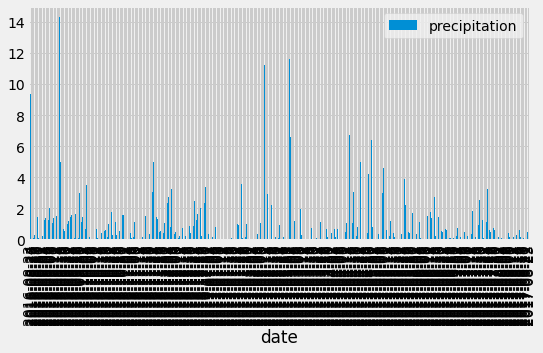

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
bar1 = precip_year_df.plot(kind='bar', figsize=(8,4), rot=90)

xticklabels = ['2016-08-23']
#bar1.set_xticklabels(xticklabels, rotation=90, rotation_mode='anchor', ha='right', wrap=True)

plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_table = precip_year_df.agg({"precipitation":["mean", "median", "var", "std", "sem"]})
summary_table

,precipitation
mean,0.978907
median,0.405000
var,3.155417
std,1.776349
sem,0.092851


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement).group_by(Measurement.station).count()

9

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement) \
    .with_entities(
        Measurement.station, 
        func.count(Measurement.station)
).group_by(
        Measurement.station
).order_by(
        func.count(Measurement.station).desc()
).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(Measurement) \
    .with_entities(
        func.min(Measurement.tobs)
).filter(
    Measurement.station.like('USC00519281') 
).all()
print(f'The lowest temperature is {min_temp}')

max_temp = session.query(Measurement) \
    .with_entities(
        func.max(Measurement.tobs)
).filter(
    Measurement.station.like('USC00519281') 
).all()
print('The highest temperature is ', max_temp)

mean_temp = session.query(Measurement) \
    .with_entities(
        func.avg(Measurement.tobs)
).filter(
    Measurement.station.like('USC00519281') 
).all()
print(f'The average temperature is {mean_temp}')


The lowest temperature is [(54.0,)]
The highest temperature is  [(85.0,)]
The average temperature is [(71.66378066378067,)]


In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 

station_df = pd.DataFrame(session.query(Measurement) \
    .with_entities(
        Measurement.date, 
        Measurement.tobs
).filter(
    Measurement.station.like('USC00519281') 
).order_by(
    Measurement.date
).all(), columns = ('date', 'temperature'))

temp_year_df = station_df[station_df['date'] >= '2016-08-23']

temp_year_df=temp_year_df.set_index('date', drop=True)

temp_year_df

,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


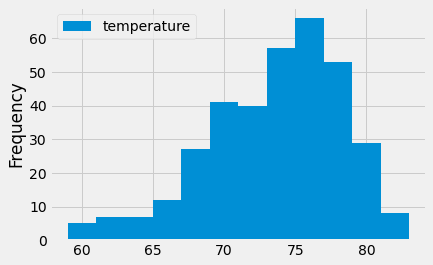

In [59]:
# plot the results as a histogram
hist1 = temp_year_df.plot.hist(bins=12)

plt.show()

# Close session

In [60]:
# Close Session
session.close()